# Problem Set 5: Trees, Forests, and Networks


## Part 1: Exploring The Titanic

Your mission for this problem set is to use your knowledge of supervised machine learning to try to predict which passengers aboard the Titanic were most likely to survive. The prompts for this part of the problem set are deliberately vague - the goal is to leave it up to you how to structure (most of) your analysis. We **highly recommend** you closely go over the entire problem set once before starting; this is important, so that you understand the sequence of steps and not perform redundant work.

To get started, read about the prediction problem on [Kaggle](https://www.kaggle.com/c/titanic). Then, download the data [here](https://www.kaggle.com/c/titanic/data) - you'll need the `train.csv` data. Treat this as your entire dataset, and further build train and test splits from this dataset whenever required. 

### 1.1 Exploratory data analysis

Create 2-3 figures and tables that help give you a feel for the data. Make sure to at least check the data type of each variable, to understand which variables have missing observations, and to understand the distribution of each variable (and determine whether the variables should be normalized or not). Are any of the potential predictor variables (i.e., anything execpt for survival) collinear or highly correlated? Remember that this is the EDA phase, and we want to save pre-processing steps like imputations, transformations etc. and feature engineering for later.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import graphviz 
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

In [2]:
titanic_data = pd.read_csv('train.csv')
titanic_data_raw = titanic_data.copy()
print(titanic_data.shape)
titanic_data.head(3)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


#### Check data types and missingness

In [3]:
missing = pd.DataFrame({"data_type": titanic_data.dtypes, "null_num": titanic_data.isnull().sum()})
missing

,data_type,null_num
PassengerId,int64,0
Survived,int64,0
Pclass,int64,0
Name,object,0
Sex,object,0
Age,float64,177
SibSp,int64,0
Parch,int64,0
Ticket,object,0
Fare,float64,0


In [4]:
# Sex and Embarked are of string type. We need to convert them into numerical values. 
#We will transform Embarked in a later step.
titanic_data['Sex_int'] = 0
titanic_data['Sex_int'][titanic_data.Sex == 'male'] = 1

#### Check distribution of each variable

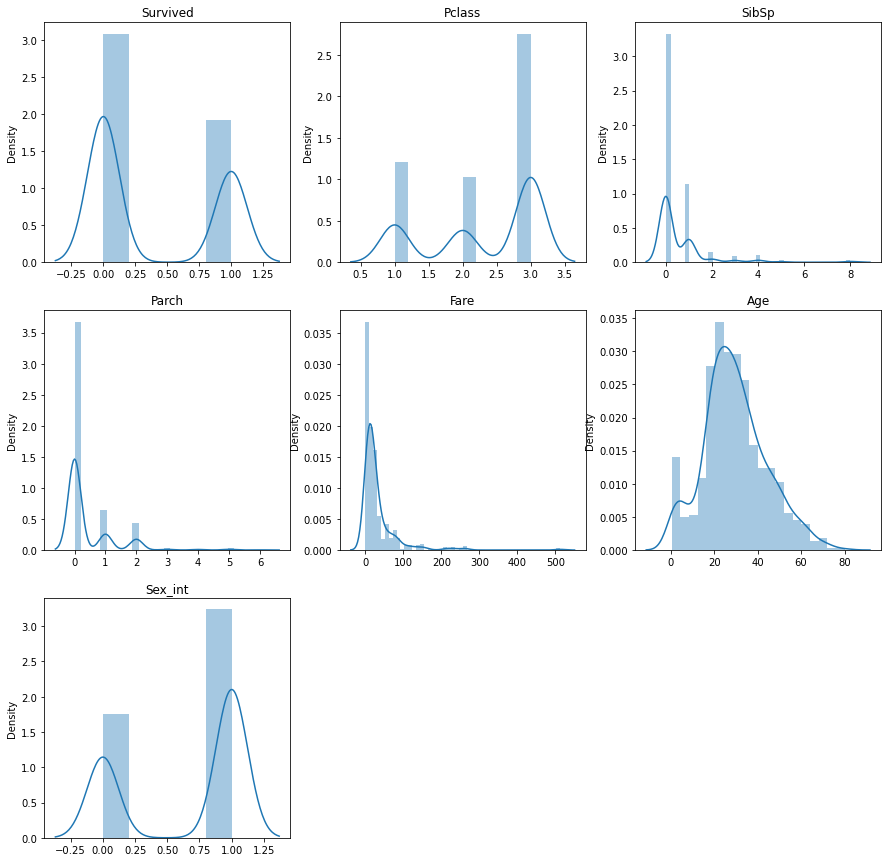

In [5]:
feature_selected = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Sex_int']
plt.figure(figsize=(15,15))
for i in range(len(feature_selected)):
    feature_this = titanic_data[feature_selected[i]]
    feature_this = feature_this.dropna()
    plt.subplot(3,3,i+1)
    plt.title(feature_selected[i])
    sns.distplot(feature_this)
    plt.xlabel('')

#### Check correlations between predictor variables

<AxesSubplot:>

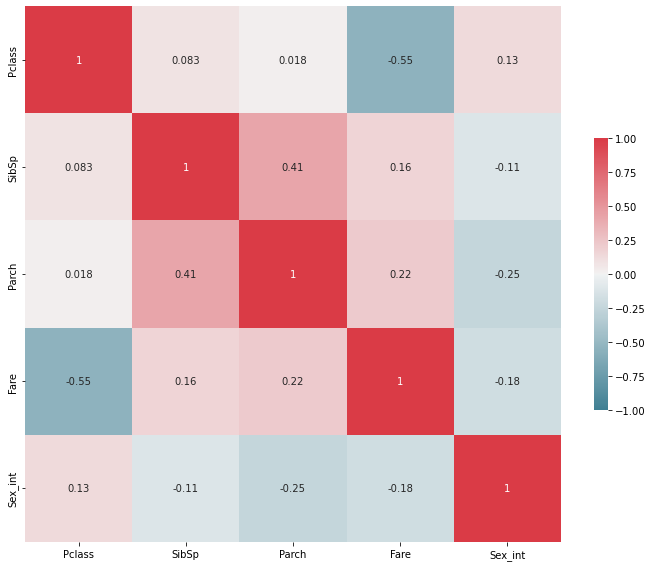

In [6]:
feature_selected = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_int']
plt.figure(figsize=(12,10))
corr = titanic_data[feature_selected].corr()
# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, annot=True, cbar_kws={'shrink':.5})

#### Example additional EDA figures

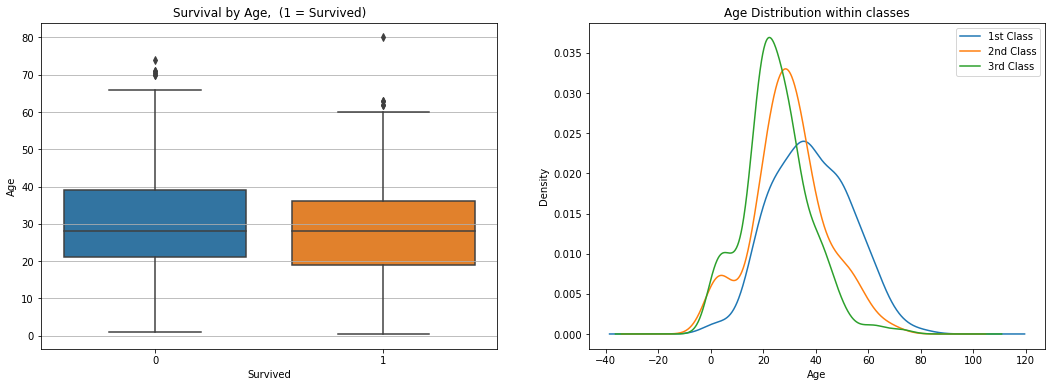

In [7]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6)) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55


plt.subplot(1,2,1)
sns.boxplot(x="Survived", y="Age", data=titanic_data)
plt.ylabel("Age")
plt.grid(b=True, which='major', axis='y')  
plt.title("Survival by Age,  (1 = Survived)")

plt.subplot(1,2,2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
titanic_data.Age[titanic_data.Pclass == 1].plot(kind='kde')    
titanic_data.Age[titanic_data.Pclass == 2].plot(kind='kde')
titanic_data.Age[titanic_data.Pclass == 3].plot(kind='kde')
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

plt.show()

#### Observations
- ***Data types:*** *Most of the fields are integers or floats. It appears that fare and age are continuous, while survived and sex are binary, and the remaining variables (Pclass, SibSp, and Parch) are either categorical or ordinal.*
- ***Missingness:*** *A couple of the variables have high missingness: Age is missing for 177 observations (20% of all observations), and cabin is missing for 687 observations (77% of all observations). Embarked is also missing for 2 observations (<1% of all observations).*
- ***Distributions***: *The distribution of fare is skewed. We may need to log transform or otherwise deal with outliers in the future. The distributions of SibSp and Parch, which appear to be ordinal variables, are also skewed -- but if we treat these as categorical in the analysis we may not need to address the issue. The distribution of age looks to be normal.*
- ***Correlations***: *There is no evidence of problematically high correlation between predictor variables. The highest correlation is between fare and class, with a negative correlation of 0.55. This makes sense, as people in a lower class are likely to have a cheaper fare. Parch and SibSp are also fairly correlated, with a positive correlation of 0.41. This also makes sense, as both are related to the size of the family on board the Titanic.*

### 1.2 Correlates of survival

Use whatever methods you can think of to try and figure out what factors seem to determine whether or not a person would survive the sinking of the Titanic. You can start with simple correlations, but will likely also want to use multiple regression and/or other methods in your toolkit. What do you conclude?

#### Simple correlations

In [8]:
r_all = []
p_all = []
for i in feature_selected:
    r, p = pearsonr(titanic_data['Survived'], titanic_data[i])
    r_all.append(r)
    p_all.append(p)
pd.DataFrame({'Feature':feature_selected, 'Correlation with Survival':r_all, 'p-value':p_all})\
    [['Feature', 'Correlation with Survival', 'p-value']]

,Feature,Correlation with Survival,p-value
0,Pclass,-0.338481,2.537047e-25
1,SibSp,-0.035322,2.922439e-01
2,Parch,0.081629,1.479925e-02
3,Fare,0.257307,6.120189e-15
4,Sex_int,-0.543351,1.406066e-69


#### Multiple linear regression

In [9]:
mod = smf.ols(formula='Survived ~ C(Pclass) + SibSp + Parch + Fare + Sex_int + C(Embarked)', data=titanic_data)
res = mod.fit()
print(res.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.371   
Dependent Variable: Survived         AIC:                837.7312
Date:               2022-04-13 15:27 BIC:                880.8421
No. Observations:   889              Log-Likelihood:     -409.87 
Df Model:           8                F-statistic:        66.47   
Df Residuals:       880              Prob (F-statistic): 3.74e-85
R-squared:          0.377            Scale:              0.14873 
-----------------------------------------------------------------
                  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         0.9466   0.0490  19.3331 0.0000  0.8505  1.0427
C(Pclass)[T.2]   -0.0930   0.0451  -2.0609 0.0396 -0.1815 -0.0044
C(Pclass)[T.3]   -0.2625   0.0410  -6.4015 0.0000 -0.3429 -0.1820
C(Embarked)[T.Q] -0.0244   0.0561  -0.4355 0.6633 -0.1345  0.0856
C(Embarked)[T.S] -0.0794   

#### Multiple logistic regression

In [10]:
import statsmodels.formula.api as smf

mod = smf.logit(formula='Survived ~ C(Pclass) + SibSp + Parch + Fare + Sex_int + C(Embarked)', data=titanic_data)
res = mod.fit()
print(res.summary2())

Optimization terminated successfully.
         Current function value: 0.455896
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.315     
Dependent Variable: Survived         AIC:              828.5824  
Date:               2022-04-13 15:27 BIC:              871.6932  
No. Observations:   889              Log-Likelihood:   -405.29   
Df Model:           8                LL-Null:          -591.41   
Df Residuals:       880              LLR p-value:      1.6156e-75
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         2.5533   0.3400   7.5105 0.0000  1.8870  3.2196
C(Pclass)[T.2]   -0.5354   0.2825  -1.8950 0.0581 -1.0891  0.0184


#### Observations
*Using simple correlations, it looks like pclass, parch, fare, and sex are all statistically significantly correlated with survival at a 0.05 level. Using multiple linear regression, being a man and being in third class are highly statistically significant in the regression (p < 0.001), with both being associated with a lower probability of survival. SibSp, being in second class, and embarking in Southampton are also statistically significant at a 0.05 level, with all being associated with a lower probability of survival. The results of the logistic regression are qualitatively similar to the results of the linear regression, with the exception that being in second class is not significant at the 0.05 level in the logistic regression. The advantage of the multiple linear and logistic regressions over the simple correlations is that the regressions give us the relationship between each predictor variable and the target after conditioning on the other predictor variables.*

### 1.3 Preprocessing steps
Take whatever pre-processing steps you believe are necessary for each variable in the dataset (for example, these might include normalization, log transforms, dummy-encoding, or dropping a variable altogether). For now, you can ignore null values in the dataset --- we'll come back to those later. Create a table describing the preprocessing step for each variable. Make sure the variables are alphabetized and your table is well-organized.

In [11]:
df = pd.get_dummies(titanic_data, columns=['Embarked', 'Pclass'], drop_first=True)
df['Fare'] = np.log(df['Fare'] + 1)
mean, std = df['Fare'].mean(), df['Fare'].std()
df['Fare'] = (df['Fare'] - mean)/std
mean, std = df['Age'].mean(), df['Age'].std()
df['Age'] = (df['Age'] - mean)/std
df = df.drop('Cabin', axis=1)

In [12]:
# Table of preprocessing steps
steps = {'Fare':'Log transformed, then standardized', 'Sex':'Converted to binary', 
         'Embarked':'One-hot encoded', 'Pclass':'One-hot encoded', 'Cabin':'Dropped',
         'Name':'No transformation', 'SibSp':'No transformation', 'Parch':'No transformation',
        'Age':'Standardized', 'PassengerId':'No transformation', 'Ticket':'No transformation'}
steps = pd.DataFrame([steps.keys(), steps.values()]).T
steps.columns = ['Variable', 'Transformation']
steps = steps.sort_values('Variable', ascending=True)
steps

,Variable,Transformation
8,Age,Standardized
4,Cabin,Dropped
2,Embarked,One-hot encoded
0,Fare,"Log transformed, then standardized"
5,Name,No transformation
7,Parch,No transformation
9,PassengerId,No transformation
3,Pclass,One-hot encoded
1,Sex,Converted to binary
6,SibSp,No transformation


## Part 2: Decision Trees
### 2.1 Decision Tree
Using the basic [Decision Tree Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)  in sklearn, fit a model to predict titanic survival, using 10-fold cross-validation. For this and the following problems, you should set aside some (20%) of your training data as held-out test data, prior to cross-validation. 

Begin by using the default hyperparameters, and report the average training and cross-validated accuracy across the 10 folds.  Then, fit a single decision tree model on all of the training data (i.e., no cross-validation in this particular step), and report the performance of this fitted model on the held-out test data -- how does it compare to the cross-validated accuracy? Finally, show a diagram of this tree (at least the first three levels of splits), and provide a couple sentences interpreting the tree diagram.

NOTE - You may drop columns with null values for now; we'll come back to those columns later in the problem set.

In [13]:
# Split data into training and test
feats_no_nulls = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_int']
df_no_nulls = pd.concat([df[[col for col in df.columns if feat in col]] for feat in feats_no_nulls], axis=1)
train, test = train_test_split(df_no_nulls, shuffle=True, test_size=0.20, random_state=1)
x_train, y_train = train.drop('Survived', axis=1), train['Survived']
x_test, y_test = test.drop('Survived', axis=1), test['Survived']

In [14]:
# Fit model over 10 fold cross validation
cv = KFold(n_splits=10, shuffle=True, random_state=2)
model = DecisionTreeClassifier()
cv_results = cross_validate(model, x_train, y_train, cv=cv, return_train_score=True)

print('Average train accuracy over 10 fold CV: %.2f' % cv_results['train_score'].mean())
print('Average test accuracy over 10 fold CV: %.2f' % cv_results['test_score'].mean())

Average train accuracy over 10 fold CV: 0.93
Average test accuracy over 10 fold CV: 0.79


In [15]:
# Fit model on all training data
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Train accuracy (all training data): %.2f' % accuracy_score(y_train, yhat_train))
print('Test accuracy (heldout test data): %.2f' % accuracy_score(y_test, yhat_test))

Train accuracy (all training data): 0.93
Test accuracy (heldout test data): 0.77


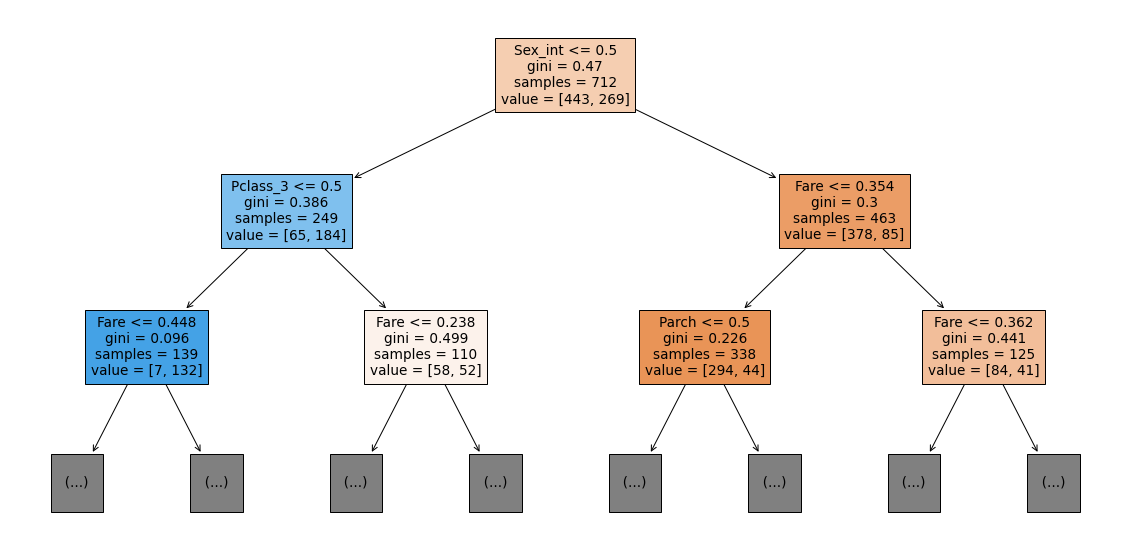

In [16]:
# Tree diagram
fig, ax = plt.subplots(1, figsize=(20, 10))
tree.plot_tree(model, feature_names=x_train.columns, filled=True, max_depth=2, ax=ax)
plt.show()

#### Observations
- ***Accuracy:*** *The accuracy on the held-out test set is approximately the same as the cross-validated accuracy over 10 fold cross validation*
- ***Interpretation of tree diagram:*** The first split, which is likely extremeley important, is on sex. Most of the remaining splits that we can see are on being in third class or the fare, suggesting that the class of the passenger was an important indication of survival for both men and women. There is also one split on Parch for men -- perhaps this makes sense because men with families were more likely to be on a lifeboat and survive than men without families. 

### 2.2 Hyperparameter: Maximum Depth

Use all of the data (minus the held-out data) to re-fit a single decision tree with `max_depth = 4` (i.e., no cross-validation). Show the tree diagram and also plot the feature importance. What do you observe? How does the performance of this tree compare to the tree from 2.1?

In [17]:
# Fit model on all training data, predict on test data
model = DecisionTreeClassifier(max_depth=4)
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Train accuracy (all training data): %.2f' % accuracy_score(y_train, yhat_train))
print('Test accuracy (heldout test data): %.2f' % accuracy_score(y_test, yhat_test))

Train accuracy (all training data): 0.82
Test accuracy (heldout test data): 0.79


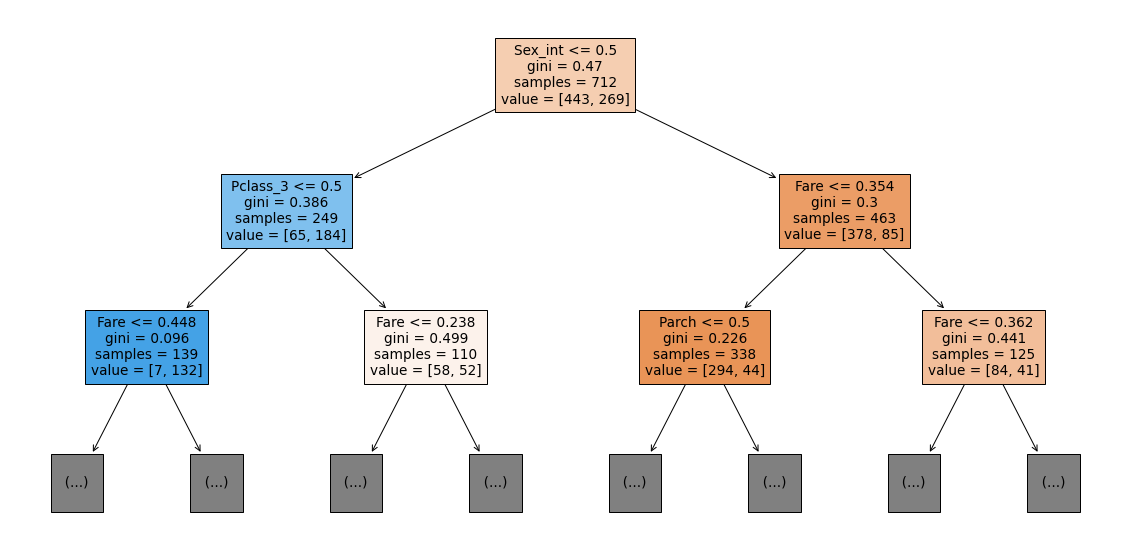

In [18]:
# Tree diagram
fig, ax = plt.subplots(1, figsize=(20, 10))
tree.plot_tree(model, feature_names=x_train.columns, filled=True, max_depth=2, ax=ax)
plt.show()

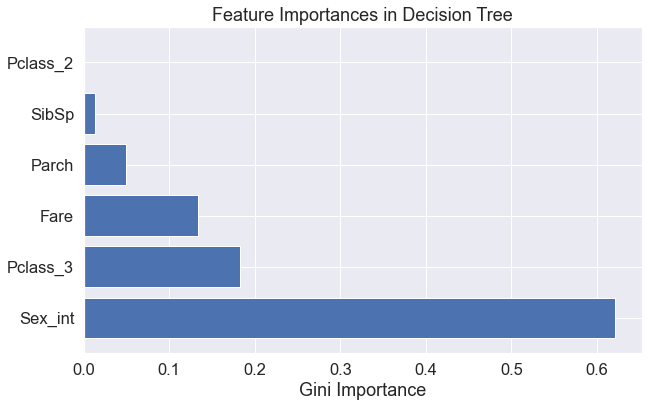

In [19]:
# Feature importances
importances = model.feature_importances_
importances = pd.DataFrame([x_train.columns, importances]).T
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=False)

# Bar chart
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
ax.set_xlabel('Gini Importance')
ax.set_title('Feature Importances in Decision Tree')
plt.show()

#### Observations
- ***Accuracy:*** The train accuracy of the tree with a maximum depth of 4 is lower than the train accuracy of a tree with unlimited depth (0.82 vs. 0.93), but the test accuracy is higher (0.79 vs. 0.77). This difference suggests that clipping the maximum depth helps the tree avoid overfitting.
- ***Feature Importances:*** The feature importances indicate that by far the most informative feature is the sex of the passenger (0.6 drop in impurity on average). Beyond that, being in 3rd class and the fare are also informative (0.1-0.2 drop in impurity on average). Being in second class does not appear to be used at all in this tree.
- ***Tree diagram:*** The tree diagram is very similar to the tree diagram from 2.1 above. That's not very surprising, as one would expect that pruning the tree would not change what the most important features are. 

### 2.3  Tuning Hyperparameters
The built-in algorithm you are using has several parameters which you can tune. Using cross-validation, show how the choice of these parameters affects performance.

First, show how `max_depth` affects train and cross-validated accuracy. On a single axis, plot train and cross-validated accuracy as a function of `max_depth`. Use a red line to show cross-validated accuracy and a blue line to show train accuracy. Do not use your held-out test data yet.

Second, show how cross-validated accuracy relates to both `max_depth` and `min_samples_leaf`. Specifically, create a 3-D plot where the x-axis is `max_depth`, the y-axis is `min_samples_leaf`, and the z-axis shows cross-validated accuracy. What combination of `max_depth` and `min-samples_leaf` achieves the highest accuracy? How sensitive are the results to these two parameters?

Finally, select the the best hyperparameters that you got through cross-validation, and fit a single decision tree on all of the training data using those hyperparameters. Display this tree and report the accuracy of this tree on the held-out data.

In [20]:
# Tuning maximum depth
model = DecisionTreeClassifier()
cv = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'max_depth':np.arange(0, 25, 1)}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
cv_results = pd.DataFrame(cv_model.cv_results_)

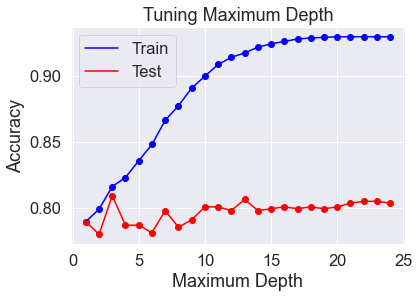

In [21]:
# Tuning maximum depth plot
fig, ax = plt.subplots(1)
ax.scatter(cv_results['param_max_depth'], cv_results['mean_train_score'], color='blue')
ax.plot(cv_results['param_max_depth'], cv_results['mean_train_score'], label='Train', color='blue')
ax.scatter(cv_results['param_max_depth'], cv_results['mean_test_score'], color='red')
ax.plot(cv_results['param_max_depth'], cv_results['mean_test_score'], label='Test', color='red')
ax.legend(loc='best')
ax.set_title('Tuning Maximum Depth')
ax.set_xlabel('Maximum Depth')
ax.set_ylabel('Accuracy')
plt.show()

In [22]:
# Tuning maximum depth and min_samples_leaf
cv = KFold(n_splits=10, shuffle=True, random_state=2)
max_depth = np.arange(1, 20)
min_leaf = np.arange(1, 20)
max_depth_X, min_leaf_Y = np.meshgrid(max_depth, min_leaf)
Z = np.zeros(shape=(len(min_leaf), len(max_depth)))
for i, d in enumerate(max_depth):
    for j, l in enumerate(min_leaf):
        clf = tree.DecisionTreeClassifier(max_depth=d, min_samples_leaf=l)
        scores = cross_validate(clf, x_train, y_train, cv=cv, return_train_score=True)
        Z[j,i] = scores['test_score'].mean()

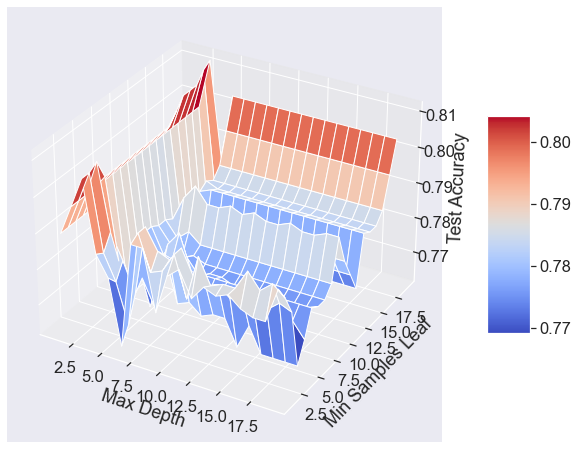

In [23]:
# Tuning maximum depth and min_samples_leaf plot
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(max_depth_X, min_leaf_Y, Z, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Min Samples Leaf')
ax.set_zlabel('Test Accuracy')
plt.show()

In [24]:
# Best maximum depth and min_samples_leaf
best_indices = np.unravel_index(Z.argmax(), Z.shape)
best_max_depth = max_depth[best_indices[1]]
best_min_samples = min_leaf[best_indices[0]]

print('Best maximum depth: %i' % best_max_depth)
print('Best min samples leaf: %i' % best_min_samples)
print('Best CV accuracy: %.2f' % np.max(Z))

model = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples)
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Train accuracy (all training data): %.2f' % accuracy_score(y_train, yhat_train))
print('Test accuracy (heldout test data): %.2f' % accuracy_score(y_test, yhat_test))

Best maximum depth: 3
Best min samples leaf: 19
Best CV accuracy: 0.81
Train accuracy (all training data): 0.81
Test accuracy (heldout test data): 0.80


#### Observations
- ***Relationship between maximum depth and accuracy:*** *The test accuracy is approximately even as maximum depth increases, while the training accuracy increases consistently, reaching close to 100% after a maximum depth of 15.
- ***Relationship between maximum depth, min samples leaf, and accuracy:*** The test accuracy is quite sensitive to the maximum depth and the minimum samples leaf. Test accuracy is consistently high with a low maximum depth -- that is, with a maximum depth below 5 it doesn't seem to matter too much what the minimum samples leaf is; maximum depth is consistently high regardless. Likewise, with a high value for min samples leaf, results are not too sensitive to the value of maximum depth. These make sense, as both having a low maximum depth or a high min samples leaf will be forms of regularization, stopping tree growth early. Test accuracy is substantially lower when there is a high value for maximum depth (>5) and a low value of minimum samples leaf (<15). 

### 2.4 Support Vector Machines, for comparison

As a starting point, use the basic [sklearn SVM model](https://scikit-learn.org/stable/modules/svm.html), with the default constant penalization (C=1), to predict survival using the same set of features as above. Report your accuracy on the test and train sets.

Next, use cross-validation to determine a possibly better choice for C. Note that regularization is inversely proportional to the value of C in sklearn, i.e. the higher value you choose for C the less you regularize. Plot a graph with C on the x-axis and cross-validated accuracy on the y-axis.
    
    
How does the test performance with SVM for your best choice of C compare to the decision tree from 2.3?

In [25]:
# Basic SVM with C=1
model = SVC(kernel='linear', C=1) 
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Train accuracy (all training data): %.2f' % accuracy_score(y_train, yhat_train))
print('Test accuracy (heldout test data): %.2f' % accuracy_score(y_test, yhat_test))

Train accuracy (all training data): 0.79
Test accuracy (heldout test data): 0.78


In [26]:
# Cross validation for C
model = SVC(kernel='linear')
cv = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'C':[0.0001, 0.001, 0.01, 0.1, 1]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
cv_results = pd.DataFrame(cv_model.cv_results_)

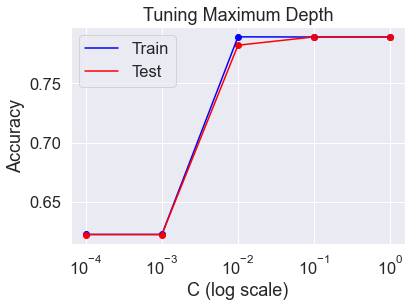

In [27]:
# Cross validation for C - plot
fig, ax = plt.subplots(1)
ax.scatter(cv_results['param_C'], cv_results['mean_train_score'], color='blue')
ax.plot(cv_results['param_C'], cv_results['mean_train_score'], label='Train', color='blue')
ax.scatter(cv_results['param_C'], cv_results['mean_test_score'], color='red')
ax.plot(cv_results['param_C'], cv_results['mean_test_score'], label='Test', color='red')
ax.set_xscale('log')
ax.legend(loc='best')
ax.set_title('Tuning Maximum Depth')
ax.set_xlabel('C (log scale)')
ax.set_ylabel('Accuracy')
plt.show()

In [28]:
# Using the best choice of C
model = cv_model.best_estimator_
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('CV accuracy: %.2f' % cv_results['mean_test_score'].max())
print('Train accuracy (all training data): %.2f' % accuracy_score(y_train, yhat_train))
print('Test accuracy (heldout test data): %.2f' % accuracy_score(y_test, yhat_test))

CV accuracy: 0.79
Train accuracy (all training data): 0.79
Test accuracy (heldout test data): 0.78


#### Observations
- *Compared to the best decision tree from earlier, the SVM doesn't achieve quite as high of a held-out test set accuracy. The difference is small, but it could result from the SVM being unable to recover a nonlinear decision boundary.*
- *The best value of C for the SVM looks to be around 0.1 or 1.*
- *We don't observe a high degree of overfitting in the SVM: the train and test accuracy are similar for all values of C.*

### 2.5 Missing Data, Imputation and Feature Engineering

Have you been paying close attention to your features? If not, now is a good time to start. Perform analysis that allows you to answer the following questions:
* Recall from part 1 that some features have missing data. Which features have missingness?
* Try running the decision tree and SVM models from part 1 using all columns, including those with missing data. What happens?
* Use one of the methods we discussed in class to impute missing values for each feature. For each feature with missingness, describe the method used and why it is appropriate to the feature.
* Find a way to engineer meaningful features from the "Name" and/or "Cabin" fields in the data.
* Rerun your decision tree and SVM on the new dataset with imputed missing values and the new features, including re-selecting hyperparameters via cross validation. What do you notice?

In [29]:
# Save unengineered data for later
y_train_original = y_train.copy()
x_train_original = x_train.copy()
y_test_original = y_test.copy()
x_test_original = x_test.copy()

In [30]:
# Running decision tree and SVM with all columns, including those with missingness
feats_with_nulls = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_int', 'Age', 'Embarked']
df_with_nulls = pd.concat([df[[col for col in df.columns if feat in col]] for feat in feats_with_nulls], axis=1)
train, test = train_test_split(df_with_nulls, shuffle=True, test_size=0.20, random_state=1)
x_train, y_train = train.drop('Survived', axis=1), train['Survived']
x_test, y_test = test.drop('Survived', axis=1), test['Survived']

In [31]:
# Try running decision tree
model = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples)
model.fit(x_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [32]:
# Try running SVM
model = SVC(C=1)
model.fit(x_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [33]:
# Deal with null values
titanic_data_with_nulls = titanic_data.copy()
titanic_data_with_nulls['Embarked'] = titanic_data_with_nulls['Embarked'].fillna('Missing')
titanic_data_with_nulls['Age'] = titanic_data_with_nulls['Age'].fillna(titanic_data_with_nulls['Age'].mean())
titanic_data_with_nulls = titanic_data_with_nulls.drop('Cabin', axis=1)
df = pd.get_dummies(titanic_data_with_nulls, columns=['Embarked', 'Pclass'], drop_first=True)
df['Fare'] = np.log(df['Fare'] + 1)
mean, std = df['Fare'].mean(), df['Fare'].std()
df['Fare'] = (df['Fare'] - mean)/std
mean, std = df['Age'].mean(), df['Age'].std()
df['Age'] = (df['Age'] - mean)/std

In [34]:
# Feature engineering from name field
df['Name_length'] = df['Name'].apply(lambda x: len(x))
df['Name_words'] = df['Name'].apply(lambda x: len(x.split(' ')))

In [35]:
# Rerun decision tree and SVM with imputed and engineered data
feats_engineered = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_int', 'Age', 'Embarked', 'Name_length',
                   'Name_words']
df_with_nulls = pd.concat([df[[col for col in df.columns if feat in col]] for feat in feats_with_nulls], axis=1)
train, test = train_test_split(df_with_nulls, shuffle=True, test_size=0.20, random_state=1)
x_train, y_train = train.drop('Survived', axis=1), train['Survived']
x_test, y_test = test.drop('Survived', axis=1), test['Survived']

In [36]:
model = DecisionTreeClassifier()
params = {'max_depth':np.arange(0, 20, 1), 'min_samples_leaf':np.arange(0, 20, 1)}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
cv_results = pd.DataFrame(cv_model.cv_results_)
model = cv_model.best_estimator_
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Best max depth (Decision Tree): %.2f' % cv_model.best_params_['max_depth'])
print('Best min samples leaf (Decision Tree): %.2f' % cv_model.best_params_['min_samples_leaf'])
print('CV accuracy (Decision Tree) : %.2f' % cv_results['mean_test_score'].max())
print('Train accuracy (Decision Tree): %.2f' % accuracy_score(y_train, yhat_train))
print('Test accuracy (Decision Tree): %.2f' % accuracy_score(y_test, yhat_test))

Best max depth (Decision Tree): 4.00
Best min samples leaf (Decision Tree): 8.00
CV accuracy (Decision Tree) : 0.83
Train accuracy (Decision Tree): 0.85
Test accuracy (Decision Tree): 0.78


In [37]:
model = SVC(kernel='linear')
params = {'C':[0.0001, 0.001, 0.01, 0.1, 1]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
cv_results = pd.DataFrame(cv_model.cv_results_)
model = cv_model.best_estimator_
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Best C (SVM): %.2f' % cv_model.best_params_['C'])
print('CV accuracy (SVM) : %.2f' % cv_results['mean_test_score'].max())
print('Train accuracy (SVM): %.2f' % accuracy_score(y_train, yhat_train))
print('Test accuracy (SVM): %.2f' % accuracy_score(y_test, yhat_test))

Best C (SVM): 0.10
CV accuracy (SVM) : 0.79
Train accuracy (SVM): 0.79
Test accuracy (SVM): 0.78


#### Observations
- ***Missingness:*** *From part 1, the three features with missingness are age, cabin, and embarked.*
- ***Incorporating null columns:*** When we try to run the models incorporating columns with null values, the models do not run out-of-the-box.
- ***Dealing with null values***: For the embarked feature, since there are only two observations with missing values and it's categorical, I added missing as an additional category for one-hot encoding. For the age feature, since it's continuous and normally distributed, I used mean imputation. For the cabin feature, since most of the observations are missing the feature, I dropped it altogether.
- ***Feature engineering from name or cabin***: I calculated two features from the name column: The number of letters in the name, and the number of words in the name.
- ***Model performance (decision tree)***: The best-performing decision tree now has a maximum depth of 7 and a min samples leaf of 5. While the training performance of the decision tree has increased from the previous part (88% accuracy vs. 81% accuracy), the testing performance is slightly lower (79% accuray vs. 80% accuracy). This suggests that the addition of new features may have caused the decision tree to overfit.
- ***Model performance (SVM)***: The best C value for the SVM is now 0.01. While the train accuracy is unchanged from before (79%), the test accuracy has also dropped a bit (76% vs. 78%). 

### 2.6 ROC Curve

For your best decision tree from 2.5, plot the reciever operating characteristic (ROC) curve on the test set data. Report the area under the curve (AUC) score. *Hint*: scikit-learn's built-in predict_proba function may be helpful for this problem.  For each model, identify the point on the ROC curve that is closest to the top-left corner, and identify the associated probability threshold for classification. Place a vertical line on your plot indicating the FPR value at the threshold. Finally, report accuracy on the test set using the threshold you identified. Comparing to the accuracy from 2.5, what do you observe? 

In [38]:
# Re-get the best model from part 2.5
model = DecisionTreeClassifier()
params = {'max_depth':np.arange(0, 20, 1), 'min_samples_leaf':np.arange(0, 20, 1)}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
model = cv_model.best_estimator_

Threshold closest to top-left corner of graph: 0.33 (0.85 TPR, 0.30 FPR)


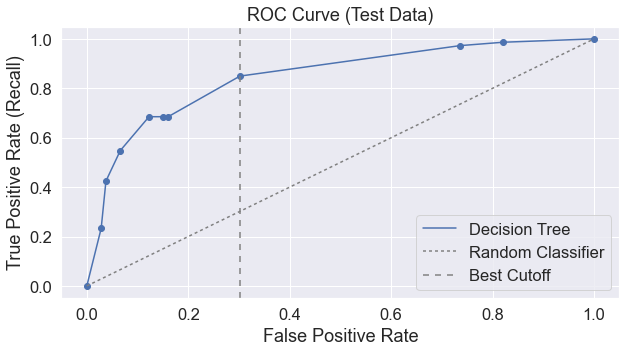

In [39]:
# Get the ROC curve
yhat_test_proba = model.predict_proba(x_test)[:, 1]
fprs, tprs, thresholds = roc_curve(y_test, yhat_test_proba)

# Get "optimal" threshold: the one closest to the top-left corner of the ROC graph
distances_from_top_left = [np.sqrt(fprs[i]**2 + (1-tprs[i])**2) for i in range(len(tprs))]
best_cutoff = np.argmin(distances_from_top_left)
print('Threshold closest to top-left corner of graph: %.2f (%.2f TPR, %.2f FPR)' % 
      (thresholds[best_cutoff], tprs[best_cutoff], fprs[best_cutoff]))

# Plot the ROC curve
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(fprs, tprs)
ax.plot(fprs, tprs, label='Decision Tree')
ax.plot([0, 1], [0, 1], color='grey', dashes=[2, 2], label='Random Classifier')
ax.axvline(fprs[best_cutoff], color='grey', dashes=[4, 4], label='Best Cutoff')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall)')
ax.set_title('ROC Curve (Test Data)')
plt.legend(loc='lower right')
plt.show()

In [40]:
yhat_test_cutoff = [1 if yhat_test_proba[i] > thresholds[best_cutoff] else 0 for i in range(len(yhat_test_proba))]
print('Number of observations in positive class: %i' % np.sum(y_test))
print('Number of observations identified as positive with standard cutoff: %i' % np.sum(yhat_test))
print('Number of observations identified as positive with new cutoff: %i' % np.sum(yhat_test_cutoff))
print('Accuracy with new cut-off: %.2f' % accuracy_score(y_test, yhat_test_cutoff))

Number of observations in positive class: 73
Number of observations identified as positive with standard cutoff: 65
Number of observations identified as positive with new cutoff: 67
Accuracy with new cut-off: 0.78


#### Observations
- *Compared to the accuracy achieved by the decision tree in question 2.5, the accuracy here is substantially lower. What's driving this change is that with the new cut-off we're identifying substantially more observations as having survived. It might make sense to accept this drop in overall accuracy if we're more concerned about false negatives than about false positives.*

## Part 3: Many Trees

### 3.1: Random Forest
Use the [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict survival on the titanic. Use cross-validation on the training data to choose the best hyper-parameters --- including the maximum depth, number of trees in the forest, and the minimum samples per leaf.
* What hyperparameters did you select with cross-validation? You should use cross-validation to select all of the hyperparameters (i.e. search a grid of hyperparameters), and report the combination that maximizes cross-validated accuracy). You can use fewer cross validation folds than the 10 folds from previous problems, to keep your code from taking too long to run.
* How does the cross-validated performance (average across validation folds) compare to the test performance (using the top-performing, fitted model selected through cross-validation)?
* How does the RF performance compare to the decision tree and SVM from part 2.5?
* Create 3 subplots that show how cross-validated performance (y-axis) relates to the number of trees in the forest (x-axis), maximum depth (x-axis), and minimum samples per leaf (x-axis). What do you observe?

In [41]:
# Grid search over all hyperparameters
model = RandomForestClassifier()
cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'max_depth':np.arange(0, 20, 3), 'min_samples_leaf':np.arange(0, 20, 3), 
          'n_estimators':[25, 50, 75, 100]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
cv_results = pd.DataFrame(cv_model.cv_results_)

In [42]:
print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best min samples leaf: %i' % cv_model.best_params_['min_samples_leaf'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])
print('Best CV accuracy: %.2f' % cv_results['mean_test_score'].max())

model = cv_model.best_estimator_
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)
print('Train accuracy of best model: %.2f' % accuracy_score(y_train, yhat_train))
print('Test accuracy of best model: %.2f' % accuracy_score(y_test, yhat_test))

Best maximum depth: 18
Best min samples leaf: 3
Best number of estimators: 75
Best CV accuracy: 0.84
Train accuracy of best model: 0.89
Test accuracy of best model: 0.78


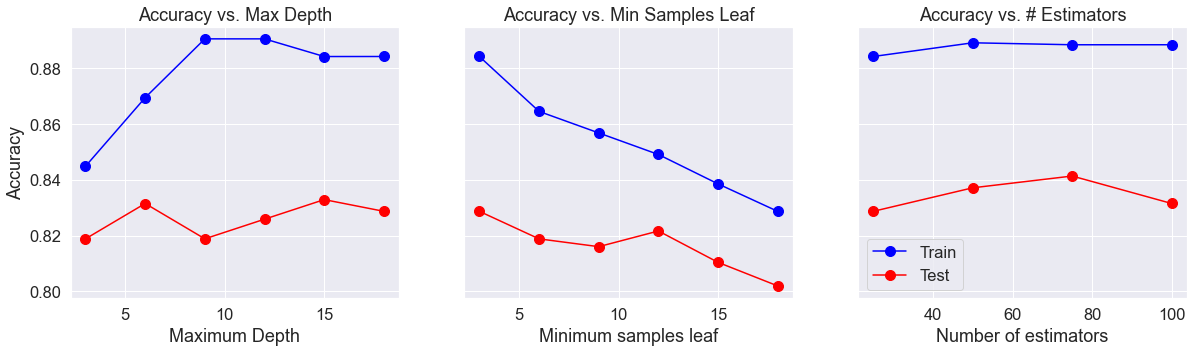

In [43]:
# Plots of relationships to hyperparameters
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

subset = cv_results[(cv_results['param_min_samples_leaf'] == 3) & (cv_results['param_n_estimators'] == 25)]
ax[0].plot(subset['param_max_depth'], subset['mean_train_score'], color='blue', marker='.', markersize=20)
ax[0].plot(subset['param_max_depth'], subset['mean_test_score'], color='red', marker='.', markersize=20)
ax[0].set_xlabel('Maximum Depth')
ax[0].set_title('Accuracy vs. Max Depth')

subset = cv_results[(cv_results['param_max_depth'] == 18) & (cv_results['param_n_estimators'] == 25)]
ax[1].plot(subset['param_min_samples_leaf'], subset['mean_train_score'], color='blue', marker='.', markersize=20)
ax[1].plot(subset['param_min_samples_leaf'], subset['mean_test_score'], color='red', marker='.', markersize=20)
ax[1].set_xlabel('Minimum samples leaf')
ax[1].set_title('Accuracy vs. Min Samples Leaf')

subset = cv_results[(cv_results['param_min_samples_leaf'] == 3) & (cv_results['param_max_depth'] == 18)]
ax[2].plot(subset['param_n_estimators'], subset['mean_train_score'], color='blue', label='Train', 
           marker='.', markersize=20)
ax[2].plot(subset['param_n_estimators'], subset['mean_test_score'], color='red', label='Test', marker='.', 
           markersize=20)
ax[2].set_xlabel('Number of estimators')
ax[2].set_title('Accuracy vs. # Estimators')
ax[2].legend(loc='best')

ax[0].set_ylabel('Accuracy')
plt.show()

#### Observations
- ***Comparison between CV and test performance:*** *The test performance of the random forest is a bit lower than the CV performance (80% vs. 84%).* 
- ***Comparison to decision tree:*** *The CV performance of the random forest is substantially higher than the CV performance of the decision tree, but the test accuracy is only a little higher (80% vs. 79%).*
- ***Hyperparameter tuning:*** *Cross-validated performance increases with the maximum depth up to a point (5), but then starts to decrease again, signalling overfitting. The minimum samples leaf is best when it is lowest, likely because maximum depth is already taking care of overfitting. The number of estimators does not appear to have much of an effect on cross-validated accuracy.*

### 3.2: Gradient Boosting

Use the [Gradient Boosting classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to predict survival on the Titanic. Tune your hyperparameters with cross validation. Again, you should tune more parameteres than just `max_depth`.
* How does the GBM performance compare to the other models?
* Create a figure showing the feature importances in your final model (with properly tuned hyperparameters)


In [44]:
# Train gradient boosting model, tune hyperparameters
model = GradientBoostingClassifier(loss='exponential')
params = {'max_depth':np.arange(0, 20, 5), 'learning_rate':[0.001, 0.01, 0.1], 'n_estimators':[25, 50, 75]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
cv_results = pd.DataFrame(cv_model.cv_results_)
model = cv_model.best_estimator_
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Chosen parameters:')
print(cv_model.best_params_)
print('CV accuracy (GBM): %.2f' % cv_results['mean_test_score'].max())
print('Train accuracy (GBM): %.2f' % accuracy_score(y_train, yhat_train))
print('Test accuracy (GBM): %.2f' % accuracy_score(y_test, yhat_test))

Chosen parameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 25}
CV accuracy (GBM): 0.84
Train accuracy (GBM): 0.89
Test accuracy (GBM): 0.79


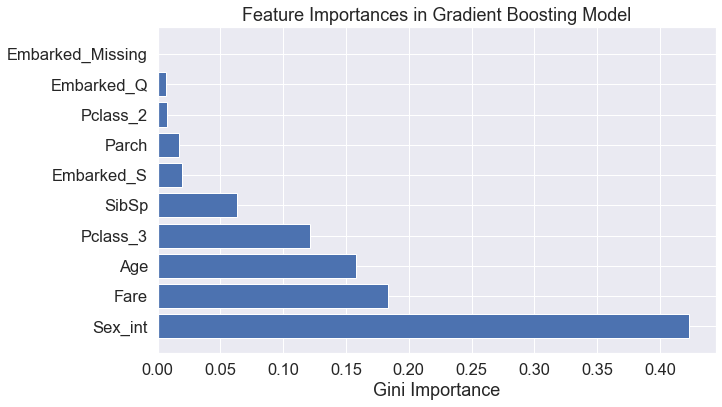

In [45]:
# Feature importances
importances = model.feature_importances_
importances = pd.DataFrame([x_train.columns, importances]).T
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=False)

# Bar chart
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
ax.set_xlabel('Gini Importance')
ax.set_title('Feature Importances in Gradient Boosting Model')
plt.show()

#### Observations
- ***Accuracy***: *The accuracy is the same as other models (79% on the test set).*
- ***Feature importances***: *The feature importances are similar to the ones we observed earlier in the decision tree. Again, sex is by far the most important, followed by fare. Now that we've added age as a predictor variable, age is more important than being in third class for determining survival.*

## Part 4: Neural Networks

Carry on the classification by using feed forward neural networks, using functionality imported from [keras](https://keras.io/api/). You are responsible for choosing the number of layers, their corresponding size, the activation functions and the choice of gradient descent algorithm (and its parameters e.g. learning rate). Pick those parameters by hand. For some of them you can also perform cross-validation if you wish, but cross validation is not required. Your goal is to tune those parameters so that your test accuracy is at least above 75%. 

Report your accuracy on the test set along with your choice of parameters. More specifically, report the number of layers, their size, the activation functions and your choice of optimization algorithm. 

It is a good exercise to experiment with different optimizers (gradient descent, stochastic gradient descent, AdaGrad etc), learning rates, batch sizes etc. to get a feeling of how they affect neural network training. Experiment with some of these options. What do you observe?

In [46]:
# Define NN
model = Sequential()
model.add(Dense(20, input_dim=len(x_train.columns), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit and predict with NN
model.fit(x_train, y_train, epochs=50, batch_size=10, verbose=0)
yhat_train = (model.predict(x_train) > 0.5).astype(int)
yhat_test = (model.predict(x_test) > 0.5).astype(int)

# Get metrics
print('Accuracy on training set: %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy on test set: %.2f' % accuracy_score(y_test, yhat_test))

Accuracy on training set: 0.86
Accuracy on test set: 0.78


#### Observations
- ***Epochs***: I experimented with using 50, 100, or 150 epochs for training. Interestingly, there was higher accuracy associated with fewer training epochs, suggesting that early stopping might be helpful for this model.
- ***Optimizer***: I experimented with gradient SGD, Adagrad, and Adam for the optimizer. I got the highest test set accuracy with adam, and the lowest with adagrad -- though it's possible adagrad would have needed additional epochs to converge. 
- ***Number of layers***: I experimented with having between 1 and 4 hidden layers. Accuracy was not improved with additional hidden layers, suggesting that very complicated networks might be overfitting for this dataset. 
- ***Number of nodes***: I experimented with between 5 and 20  nodes in each of the hidden layers. Adding additional nodes did seem to improve accuracy when there was only one hidden layer, so I decided to use 20 nodes in the hidden layer. 
- ***Activation functions***: I experimented with sigmoid and hinge activiation functions for the hidden layer. There was better accuracy with hinge, so I stuck with that.
- ***Final network***: My final networks uses one hidden layer with 20 nodes. I use a relu activiation function for the hidden layer and used the adam optimizer.

## Part 5: Putting it all together!

Create a final table that summarizes the performance of your models as follows. What do you observe? Are there trends in which models and hyperparameters work best?

| Model | Cross-validated Performance   | Train Performance | Test Performance | Chosen Hyperparameters | 
|------|------|------| | |
|   Decision Tree        | 81% | 81% | 80% | Max depth = 3, Min samples leaf = 19 |
|   Decision Tree (with imputed missing values and new features)        | 83% | 85% | 78% | Max depth = 4, Min samples leaf = 8 |
|   SVM  | 79% | 79% | 78% | C = 0.1 |
|   SVM (with imputed missing values and new features)        | 79% | 79% | 78% | C=0.1 |
|   Random Forest        | 81% | 82% | 79% | Max depth=5, Min samples leaf = 10, Trees = 25 |
|   Random Forest (with imputed missing values and new features)        | 84% | 90%  | 78% | Max depth = 18, Min samples leaf = 3, Trees = 100|
|   Gradient Boosting    | 81% | 90% | 76% | Max depth = 5, Trees = 50, Learning rate = 0.1|
|   Gradient Boosting (with imputed missing values and new features)        | 84% | 90%   | 78% | Max depth = 5, Trees = 25, Learning rate = 0.1 |
|   Neural Network    | N/A | 81% | 78% | Layers = 1, Nodes = 20, Activiation = Relu, Optimizer=adam |
|   Neural Network (with imputed missing values and new features)        | N/A  | 81%   | 78% | Layers = 1, Nodes = 20, Activiation = Relu, Optimizer=adam |

In [47]:
# Run random forest on unengineered data
model = RandomForestClassifier()
cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'max_depth':np.arange(0, 20, 5), 'min_samples_leaf':np.arange(0, 20, 5), 
          'n_estimators':[25, 50, 75, 100]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train_original, y_train_original)
cv_results = pd.DataFrame(cv_model.cv_results_)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best min samples leaf: %i' % cv_model.best_params_['min_samples_leaf'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])
print('Best CV accuracy: %.2f' % cv_results['mean_test_score'].max())

model = cv_model.best_estimator_
model.fit(x_train_original, y_train_original)
yhat_train = model.predict(x_train_original)
yhat_test = model.predict(x_test_original)
print('Train accuracy of best model: %.2f' % accuracy_score(y_train_original, yhat_train))
print('Test accuracy of best model: %.2f' % accuracy_score(y_test_original, yhat_test))

Best maximum depth: 10
Best min samples leaf: 5
Best number of estimators: 25
Best CV accuracy: 0.80
Train accuracy of best model: 0.85
Test accuracy of best model: 0.77


In [48]:
# Run gradient boosting model on unengineered data
model = GradientBoostingClassifier(loss='exponential')
params = {'max_depth':np.arange(0, 20, 5), 'learning_rate':[0.001, 0.01, 0.1], 'n_estimators':[25, 50, 75]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train_original, y_train_original)
cv_results = pd.DataFrame(cv_model.cv_results_)
model = cv_model.best_estimator_
yhat_train = model.predict(x_train_original)
yhat_test = model.predict(x_test_original)

print('Chosen parameters:')
print(cv_model.best_params_)
print('CV accuracy (GBM): %.2f' % cv_results['mean_test_score'].max())
print('Train accuracy (GBM): %.2f' % accuracy_score(y_train_original, yhat_train))
print('Test accuracy (GBM): %.2f' % accuracy_score(y_test_original, yhat_test))

Chosen parameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
CV accuracy (GBM): 0.81
Train accuracy (GBM): 0.90
Test accuracy (GBM): 0.76


In [49]:
# Run neural network on unengineered data
model = Sequential()
model.add(Dense(20, input_dim=len(x_train_original.columns), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit and predict with NN
model.fit(x_train_original, y_train_original, epochs=50, batch_size=10, verbose=0)
yhat_train = (model.predict(x_train_original) > 0.5).astype(int)
yhat_test = (model.predict(x_test_original) > 0.5).astype(int)

# Get metrics
print('Accuracy on training set: %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy on test set: %.2f' % accuracy_score(y_test, yhat_test))

Accuracy on training set: 0.82
Accuracy on test set: 0.78


#### Observations
*In general, for this problem it seems like simpler models actually work best. The basic decision tree actually achieves the highest test set performance (80%), and the random forest the second highest (79%). All of the more complex models (e.g. gradient boosting, neural networks) achieve 78% accuracy on the test set. This suggests that because our dataset is relatively simple, more complex models may be overkill (and overfitting), as demonstrated by the much higher training set than test set accuracy, even after optimally tuning hyerparameters. Interestingly, we also observe that models using the more complex feature set are generally somewhat worse than models using the basic feature set -- again, this could indicate that the more complex feature set is leading to overfitting (or could indicate that we did not engineer good features from the data).* 

## Part 6: (Extra credit) Flex your ML chops

Add additional rows to the table from Part 5 based on other models you've learned in class.
 - Which models perform the best, using the default parameters (i.e., no hyperparameter tuning)?
 - How do models perform in terms of performance metrics beyond accuracy? (e.g. AUC score, precision, recall) 
 - For which models does careful hyperparameter tuning make the biggest different? Why do you think that is the case?
 - Which tuned model has the largest gap between cross-validated performance and test performance? Why might that be?

In [ ]:
# enter your code here

*Enter your observations here*